#### TRY ALTERNATIVE SPECIFICATIONS AND EXPLORE IN MORE DETAIL LSTM MODEL BUILDING OPTIONS ####

In [1]:

import os 
from datetime import datetime


strat = 'Strat_6'
directory = os.getcwd().replace("\\", "/")
file_dir = directory
directory = directory.replace(strat, '')
parent_dir = directory
os.chdir(directory)
print(directory)

import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import module_1.Preprocessing_functions as pf 
import module_1.techinical_analysis as tech 
import module_1.LSTM_Architecture as ls 


c:/Users/User/Documents/ATS_Development/


In [2]:
ticker = 'SPY'

# Download SPY data from Yahoo Finance
def download_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)
    return data

# Feature Engineering: Add momentum features
def add_features1(data):
    data['Return'] = data['Close'].pct_change()
    data['SMA_5'] = data['Close'].rolling(window=5).mean()
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['Momentum_5'] = data['Close'] / data['Close'].shift(5)
    data['RSI'] = compute_rsi(data['Close'], 14)
    data.dropna(inplace=True)
    return data


def add_features(df, model_1 = True):
    df = pf.create_momentum_feat(df, ticker)
    df = pf.technical_indicators(df).dropna()
    
    if model_1 == False:
        df = tech.reversal_patterns(df)
        df = tech.continuation_patterns(df)
        df = tech.magic_doji(df)
        
    return df
        

def compute_rsi(series, period):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Prepare data for LSTM model
def prepare_data(data, sequence_length):
    #y = (data['Close'].shift(-1) > data['Close']).astype(int)  # 1 for green, 0 for red
    
    data['labels'] = (data['Open'].shift(-1) > data['Close']).astype(int) # 0 = False : 1 = True
    
    
    y = data.pop('labels')
    
    data = data.drop(columns = ["Open",
                                "High",
                                "Low",
                                "Close",
                                "Capital Gains", 
                                "Stock Splits"
                                ]).dropna()
    
    features = list(data.columns)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data[features])
    
    
     # Create sequences
    X, y_seq = [], []
    for i in range(len(X_scaled) - sequence_length):
        X.append(X_scaled[i:i + sequence_length])
        y_seq.append(y.iloc[i + sequence_length - 1])

    return np.array(X), np.array(y_seq)
    
    #y = y[:-1]  # Remove last value since it has no next day
    #X = X[:-1]  # Match X with y length
    #return X, y


In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Load and preprocess data
#data = download_data('SPY', start='2013-01-01', end='2024-01-01')
data = pf.downlaod_symbol_data(ticker, period = '130mo')

# Training parameters
INPUT_SIZE = data.shape[0]
HIDDEN_SIZE = 50
OUTPUT_SIZE = 2
NUM_LAYERS = 2
EPOCHS = int(1e3)
BATCH_SIZE = 32
LR = 0.001
SEQUENCE_LENGTH = 50

data = add_features(data)

### DEBUGGING data
X, y = prepare_data(data, SEQUENCE_LENGTH)

print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (2438, 50, 23)
y shape:  (2438,)


In [5]:
train_size_pct = 0.7

train_size = int(train_size_pct * X.shape[0])

X_train = X[ :train_size, :]
X_test = X[train_size :, :]

y_train = y[:train_size]
y_test = y[train_size:]

print('Training set shape', X_train.shape)
print('Test set shape', X_test.shape)
print('Training Labels shape', y_train.shape)
print('Test Labels shape', y_test.shape)

Training set shape (1706, 50, 23)
Test set shape (732, 50, 23)
Training Labels shape (1706,)
Test Labels shape (732,)


In [6]:
print('Training set start date: ', data.iloc[ :train_size, :].index.min())
print('Training set end date: ', data.iloc[ :train_size, :].index.max())
print('Test set start date: ', data.iloc[train_size :, :].index.min())
print('Test set end date: ', data.iloc[train_size :, :].index.max())

Training set start date:  2015-02-23 00:00:00-05:00
Training set end date:  2021-11-29 00:00:00-05:00
Test set start date:  2021-11-30 00:00:00-05:00
Test set end date:  2025-01-10 00:00:00-05:00


In [7]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [8]:

class CustomLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        """
        Args:
            input_size (int): The number of input features.
            hidden_sizes (list): A list of hidden sizes for each LSTM layer (e.g., [128, 64, 32]).
            output_size (int): The number of output features.
        """
        super(CustomLSTMModel, self).__init__()
        self.hidden_sizes = hidden_sizes
        
        # Define the first LSTM layer
        self.lstm1 = nn.LSTM(input_size, hidden_sizes[0], batch_first=True)
        
        # Define subsequent LSTM layers
        self.lstm2 = nn.LSTM(hidden_sizes[0], hidden_sizes[1], batch_first=True)
        self.lstm3 = nn.LSTM(hidden_sizes[1], hidden_sizes[2], batch_first=True)
        
        # Fully connected layer for final output
        self.fc = nn.Linear(hidden_sizes[2], output_size)

    def forward(self, x):
        # Pass through the first LSTM layer
        out, _ = self.lstm1(x)
        
        # Pass through the second LSTM layer
        out, _ = self.lstm2(out)
        
        # Pass through the third LSTM layer
        out, _ = self.lstm3(out)
        
        # Pass the final output through the fully connected layer
        out = self.fc(out[:, -1, :])  # Use the last time-step's output
        return out


In [9]:
# Initialize model, loss, and optimizer
HIDDEN_SIZES = [128,64,32]
model = CustomLSTMModel(INPUT_SIZE, HIDDEN_SIZES, OUTPUT_SIZE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


print('outputs', outputs.shape)
print('y_train', y_train.shape)

train_predictions[3]

In [10]:

results = {}

best_epoch = 0
best_accuracy = 0 
best_model_name = ''

# Training loop
for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Evaluate on training set
    with torch.no_grad():
        train_predictions = outputs.argmax(dim=1)
        train_accuracy = accuracy_score(y_train, train_predictions)
        train_precision = precision_score(y_train, train_predictions, average='weighted', zero_division=0)
        train_recall = recall_score(y_train, train_predictions, average='weighted', zero_division=0)
        train_f1 = f1_score(y_train, train_predictions, average='weighted', zero_division=0)

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_predictions = val_outputs.argmax(dim=1)
        val_accuracy = accuracy_score(y_test, val_predictions)
        val_precision = precision_score(y_test, val_predictions, average='weighted', zero_division=0)
        val_recall = recall_score(y_test, val_predictions, average='weighted', zero_division=0)
        val_f1 = f1_score(y_test, val_predictions, average='weighted', zero_division=0)

    
    if val_accuracy > best_accuracy: 
        
        best_accuracy = val_accuracy
        best_epoch = epoch
        
        DATE = datetime.today().strftime('%Y%m%d%H%M')
        MODEL_PATH = Path(file_dir + f"/lstm_models/{ticker}")
        MODEL_PATH.mkdir(parents = True, exist_ok = True)
        
        # CREATE MODEL SAVE PATH
        MODEL_NAME = f"LSTM_Class_Epoch_{epoch}_TestAcc_{val_accuracy:.2f}_TrainAcc_{train_accuracy:.2F}_{DATE}"
        MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
        best_model_pathname = MODEL_SAVE_PATH
        # SAVE MODEL STATE DICT
        print(f"Saving model to: {MODEL_SAVE_PATH}")
        torch.save(obj = model.state_dict(), f = MODEL_SAVE_PATH)
        
        
    
    results[epoch]  = [(train_accuracy, val_accuracy)]
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")


Saving model to: c:\Users\User\Documents\ATS_Development\Strat_6\lstm_models\SPY\LSTM_Class_Epoch_0_TestAcc_0.53_TrainAcc_0.57_202501111825
Epoch [1/2000], Loss: 0.6886, Train Accuracy: 0.5674, Train Precision: 0.3220, Train Recall: 0.5674, Train F1: 0.4108, Val Accuracy: 0.5301, Val Precision: 0.2810, Val Recall: 0.5301, Val F1: 0.3673
Epoch [2/2000], Loss: 0.6869, Train Accuracy: 0.5674, Train Precision: 0.3220, Train Recall: 0.5674, Train F1: 0.4108, Val Accuracy: 0.5301, Val Precision: 0.2810, Val Recall: 0.5301, Val F1: 0.3673
Epoch [3/2000], Loss: 0.6855, Train Accuracy: 0.5674, Train Precision: 0.3220, Train Recall: 0.5674, Train F1: 0.4108, Val Accuracy: 0.5301, Val Precision: 0.2810, Val Recall: 0.5301, Val F1: 0.3673
Epoch [4/2000], Loss: 0.6844, Train Accuracy: 0.5674, Train Precision: 0.3220, Train Recall: 0.5674, Train F1: 0.4108, Val Accuracy: 0.5301, Val Precision: 0.2810, Val Recall: 0.5301, Val F1: 0.3673
Epoch [5/2000], Loss: 0.6835, Train Accuracy: 0.5674, Train Prec

In [11]:
### LOAD THE BEST MDOEL
# LOAD LSTM MODEL STATE DICT  
model.load_state_dict(torch.load(f = best_model_pathname ))

<All keys matched successfully>

In [12]:
# Evaluate model
model.eval()
with torch.no_grad():
    predictions = model(X_test).argmax(dim=1)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.55


In [13]:
pd.DataFrame(val_predictions).value_counts()

1    509
0    223
Name: count, dtype: int64

Text(0, 0.5, 'Accuracy')

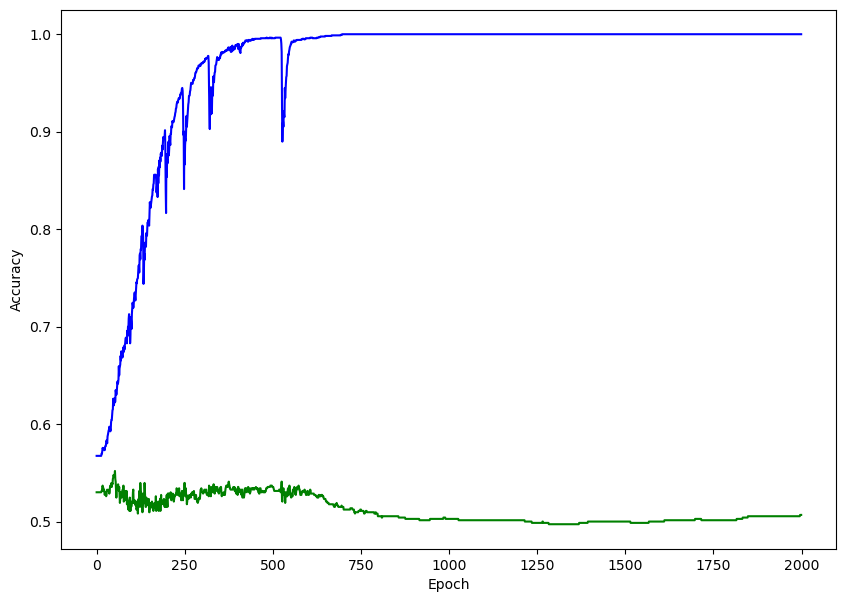

In [14]:

### plot training 
res = pd.DataFrame(results.values())
res.columns = ['tuple']

res['train_acc'] = res['tuple'].apply(lambda x : x[0])
res['test_acc'] = res['tuple'].apply(lambda x : x[1])

del res['tuple']
res.index = results.keys()


import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(res.index, res['train_acc'], color = 'b')
plt.plot(res.index, res['test_acc'], color = 'green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [16]:
res.test_acc.max()

0.5519125683060109